In [11]:
import pandas as pd

df_click = pd.read_csv('click_stream.csv')
df_txn = pd.read_csv('transactions.csv')
df_user = pd.read_csv('customer.csv')
df_prod = pd.read_csv('product.csv', on_bad_lines='skip')


# Check the dataset
print("click_stream.csv:")
print(df_click.info(), "\n")
print(df_click.isnull().sum(), "\n")

print("transactions.csv:")
print(df_txn.info(), "\n")
print(df_txn.isnull().sum(), "\n")

print("customer.csv:")
print(df_user.info(), "\n")
print(df_user.isnull().sum(), "\n")

print("product.csv:")
print(df_prod.info(), "\n")
print(df_prod.isnull().sum(), "\n")

click_stream.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12833602 entries, 0 to 12833601
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   session_id      object
 1   event_name      object
 2   event_time      object
 3   event_id        object
 4   traffic_source  object
 5   event_metadata  object
dtypes: object(6)
memory usage: 587.5+ MB
None 

session_id              0
event_name              0
event_time              0
event_id                0
traffic_source          0
event_metadata    8544062
dtype: int64 

transactions.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852584 entries, 0 to 852583
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   created_at              852584 non-null  object 
 1   customer_id             852584 non-null  int64  
 2   booking_id              852584 non-null  object 
 3   session_id          

In [ ]:
# --- 處理 transactions ---
df_txn['promo_code'] = df_txn['promo_code'].fillna('none')
df_txn['created_at'] = pd.to_datetime(df_txn['created_at'])
df_txn['shipment_date_limit'] = pd.to_datetime(df_txn['shipment_date_limit'])

# --- 處理 click_stream ---
df_click['event_time'] = pd.to_datetime(df_click['event_time'])
# 不處理 event_metadata，保留 NaN 是有意義的

# --- 處理 customer ---
df_user['birthdate'] = pd.to_datetime(df_user['birthdate'], errors='coerce')
df_user['first_join_date'] = pd.to_datetime(df_user['first_join_date'], errors='coerce')

# --- 處理 product ---
df_prod['baseColour'] = df_prod['baseColour'].fillna('unknown')
df_prod['season'] = df_prod['season'].fillna('unknown')
df_prod['usage'] = df_prod['usage'].fillna('unknown')
df_prod['productDisplayName'] = df_prod['productDisplayName'].fillna('unknown')

In [ ]:
print(df_click['session_id'].nunique(), df_txn['session_id'].nunique())
print(df_txn['customer_id'].nunique(), df_user['customer_id'].nunique())
print(df_txn['product_metadata'].head())

895203 852584
50705 100000
0    [{'product_id': 54728, 'quantity': 1, 'item_pr...
1    [{'product_id': 16193, 'quantity': 1, 'item_pr...
2    [{'product_id': 53686, 'quantity': 4, 'item_pr...
3    [{'product_id': 20228, 'quantity': 1, 'item_pr...
4    [{'product_id': 55220, 'quantity': 1, 'item_pr...
Name: product_metadata, dtype: object


In [ ]:
import ast

# 將 product_metadata 轉成 list of dict
df_txn['product_metadata'] = df_txn['product_metadata'].apply(ast.literal_eval)

# 展開每一筆 product 為單一列
df_txn_exploded = df_txn.explode('product_metadata', ignore_index=True)

# 提取 product_id、quantity、item_price
df_txn_exploded['product_id'] = df_txn_exploded['product_metadata'].apply(lambda x: x.get('product_id') if isinstance(x, dict) else None)
df_txn_exploded['quantity'] = df_txn_exploded['product_metadata'].apply(lambda x: x.get('quantity') if isinstance(x, dict) else None)
df_txn_exploded['item_price'] = df_txn_exploded['product_metadata'].apply(lambda x: x.get('item_price') if isinstance(x, dict) else None)

# 清除掉原本的 product_metadata 欄位
df_txn_exploded.drop(columns=['product_metadata'], inplace=True)


In [ ]:
df_click_txn = df_click.merge(df_txn[['session_id', 'payment_status', 'customer_id']], on='session_id', how='left')

# 再與 customer 資訊合併
df_click_txn_user = df_click_txn.merge(df_user, on='customer_id', how='left')

# 用剛剛 explode 過的 transaction，加入 product 資訊
df_click_txn_user_prod = df_click_txn_user.merge(df_txn_exploded[['session_id', 'product_id']], on='session_id', how='left')
df_click_txn_user_prod = df_click_txn_user_prod.merge(df_prod, left_on='product_id', right_on='id', how='left')

df_click_txn_user_prod = df_click_txn_user_prod.copy()

In [ ]:
df_click_txn_user_prod.to_csv('full_session_dataset.csv', index=False)
# save it as csv file to prevent re-running the merge.

In [ ]:
print("Dataset shape:", df_click_txn_user_prod.shape)
print("Columns:\n", df_click_txn_user_prod.columns.tolist())

Dataset shape: (21130155, 33)
Columns:
 ['session_id', 'event_name', 'event_time', 'event_id', 'traffic_source', 'event_metadata', 'payment_status', 'customer_id', 'first_name', 'last_name', 'username', 'email', 'gender_x', 'birthdate', 'device_type', 'device_id', 'device_version', 'home_location_lat', 'home_location_long', 'home_location', 'home_country', 'first_join_date', 'product_id', 'id', 'gender_y', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']


**UX funnel**

In [ ]:
# 新增 conversion 標籤（1: 成功付款, 0: 沒有付款）
df_click_txn_user_prod['converted'] = df_click_txn_user_prod['payment_status'].apply(lambda x: 1 if x == 'Success' else 0)

# 顯示轉換率
conversion_rate = df_click_txn_user_prod['converted'].mean()
print(f"UX funnel-based conversion rate: {conversion_rate:.4f}")

UX funnel-based conversion rate: 0.9412


In [ ]:
# 4A
event_counts = df_click_txn_user_prod.groupby(['session_id', 'event_name']).size().unstack(fill_value=0).reset_index()

# 改欄位名稱，讓它變成明確的 feature name
event_counts.columns.name = None
event_counts.columns = ['session_id'] + [f'event_count_{col}' for col in event_counts.columns[1:]]

# 檢查前幾筆資料
print(event_counts.head())


                             session_id  event_count_ADD_PROMO  \
0  00001f29-3ede-4445-95f0-0178934e32ba                      0   
1  00003eca-954b-4150-aee1-63fc62f395cf                      0   
2  0000425b-ddc8-4459-a240-6ba814dac132                      0   
3  00005746-17ec-449c-9c5c-699a3ea9304a                      0   
4  0000649b-9514-4600-979b-42166a798996                      1   

   event_count_ADD_TO_CART  event_count_BOOKING  event_count_CLICK  \
0                        1                    1                  2   
1                        1                    1                  0   
2                        1                    1                  0   
3                        1                    1                 23   
4                        3                    1                  3   

   event_count_HOMEPAGE  event_count_ITEM_DETAIL  event_count_PROMO_PAGE  \
0                     2                        1                       0   
1                     1       

In [ ]:
#4B

# 先將 birthdate 轉為 datetime 格式（避免錯誤）
df_click_txn_user_prod['birthdate'] = pd.to_datetime(df_click_txn_user_prod['birthdate'], errors='coerce')

# 計算年齡（用 event_time 的年份減去出生年）
df_click_txn_user_prod['age'] = df_click_txn_user_prod['event_time'].dt.year - df_click_txn_user_prod['birthdate'].dt.year

# 可選：移除不合理的年齡（例如 <10 或 >100）
df_click_txn_user_prod = df_click_txn_user_prod[df_click_txn_user_prod['age'].between(10, 100)]

# 建立年齡分箱（分群）
age_bins = [0, 18, 25, 35, 45, 60, 100]
age_labels = ['<18', '18-25', '26-35', '36-45', '46-60', '60+']
df_click_txn_user_prod['age_group'] = pd.cut(df_click_txn_user_prod['age'], bins=age_bins, labels=age_labels)

# 取出 customer 和 device 特徵欄（包含 age_group）
customer_device_features = df_click_txn_user_prod[['session_id', 'gender_x', 'device_type', 'device_version', 'age_group']].drop_duplicates()

# One-hot encoding：轉換成模型可用格式
customer_device_encoded = pd.get_dummies(customer_device_features, 
 columns=['gender_x', 'device_type', 'device_version', 'age_group'], 
 prefix=['gender', 'device', 'version', 'age'])

# 查看結果確認
print(customer_device_encoded.head())


                               session_id  gender_F  gender_M  device_Android  \
2    7d440441-e67a-4d36-b324-80ffd636d166      True     False            True   
11   f7b5cd60-4f87-4b3c-8bde-c7da8930eec2      True     False            True   
227  b2843a94-248f-429e-bd54-1a456b4ef4a7      True     False            True   
231  d9aaa8a8-5e60-4e1e-ab0a-bb9755a7a3e9      True     False            True   
258  98e66f53-f24f-4238-8c9c-34a0482e22d5      True     False            True   

     device_iOS  version_Android 1.0  version_Android 1.1  \
2         False                False                False   
11        False                False                False   
227       False                False                False   
231       False                False                False   
258       False                False                False   

     version_Android 1.5  version_Android 1.6  version_Android 10  ...  \
2                  False                False               False  ...  

In [ ]:
# 4C Product-level Features

product_features = df_click_txn_user_prod.groupby('session_id').agg({
    'baseColour': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'masterCategory': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'subCategory': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'articleType': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'season': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'year': 'mean',
    'usage': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
}).reset_index()

# 將類別欄位進行 One-hot encoding
product_features_encoded = pd.get_dummies(
    product_features,
    columns=['baseColour', 'masterCategory', 'subCategory', 'articleType', 'season', 'usage'],
    prefix=['color', 'category', 'subcategory', 'type', 'season', 'usage']
)

# 查看結果
print(product_features_encoded.shape)
print(product_features_encoded.head())

(847349, 264)
                             session_id    year  color_Beige  color_Black  \
0  00001f29-3ede-4445-95f0-0178934e32ba  2012.0        False         True   
1  00003eca-954b-4150-aee1-63fc62f395cf  2012.0        False         True   
2  0000425b-ddc8-4459-a240-6ba814dac132  2017.0        False        False   
3  00005746-17ec-449c-9c5c-699a3ea9304a  2011.0        False         True   
4  0000649b-9514-4600-979b-42166a798996  2012.0        False         True   

   color_Blue  color_Bronze  color_Brown  color_Burgundy  color_Charcoal  \
0       False         False        False           False           False   
1       False         False        False           False           False   
2       False         False        False           False           False   
3       False         False        False           False           False   
4       False         False        False           False           False   

   color_Coffee Brown  ...  usage_Casual  usage_Ethnic  usage_Form

In [ ]:
#4D Temporal Features

df_click_txn_user_prod['event_time'] = pd.to_datetime(df_click_txn_user_prod['event_time'])

# 製作 session-level 時間欄位：選擇每個 session 的第一筆 event_time（代表該 session 開始時間）
session_times = df_click_txn_user_prod.groupby('session_id')['event_time'].min().reset_index()

# 製作時間特徵欄位
session_times['day_of_week'] = session_times['event_time'].dt.dayofweek  # 0=Monday, 6=Sunday
session_times['hour_of_day'] = session_times['event_time'].dt.hour       # 幾點鐘
session_times['week_of_month'] = session_times['event_time'].apply(lambda x: (x.day - 1) // 7 + 1)

# 檢查結果
print(session_times[['session_id', 'event_time', 'day_of_week', 'hour_of_day', 'week_of_month']].head())

# 最後把時間特徵留下，準備與其他 features 合併
temporal_features = session_times[['session_id', 'day_of_week', 'hour_of_day', 'week_of_month']]

                             session_id                       event_time  \
0  00001f29-3ede-4445-95f0-0178934e32ba 2019-05-17 11:51:52.276396+00:00   
1  00003eca-954b-4150-aee1-63fc62f395cf 2019-08-24 05:47:16.849738+00:00   
2  0000425b-ddc8-4459-a240-6ba814dac132 2019-02-05 13:38:59.490443+00:00   
3  00005746-17ec-449c-9c5c-699a3ea9304a 2022-03-08 23:17:19.510057+00:00   
4  0000649b-9514-4600-979b-42166a798996 2020-07-17 13:32:48.525079+00:00   

   day_of_week  hour_of_day  week_of_month  
0            4           11              3  
1            5            5              4  
2            1           13              1  
3            1           23              2  
4            4           13              3  


In [ ]:
successful_sessions = set(df_txn[df_txn['payment_status'] == 'Success']['session_id'])

# 建立一個 converted label dataframe，標記是否成功轉換
converted_labels = df_click[['session_id']].drop_duplicates()
converted_labels['converted'] = converted_labels['session_id'].apply(lambda x: 1 if x in successful_sessions else 0)

In [ ]:
from functools import reduce
dfs = [event_counts, customer_device_encoded, product_features_encoded, temporal_features]
df_features = reduce(lambda left, right: pd.merge(left, right, on='session_id', how='outer'), dfs)

df_final = df_features.merge(converted_labels, on='session_id', how='left')

df_final.to_csv('final_project_features.csv', index=False)

Feature Modeling

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Step 1：讀取完整特徵資料
df = pd.read_csv('final_project_features.csv')

# Step 2：前處理
df_clean = df.dropna()

# Step 3：拆分 X 和 y
X = df_clean.drop(columns=['session_id', 'converted'])
y = df_clean['converted']

# Step 4：資料標準化（Logistic Regression 需要）

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5：切分訓練與測試集

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Step 6：建模與評估

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
logreg_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])


# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

# Compare Results
results = pd.DataFrame([
    {
        'Model': 'Logistic Regression',
        'Accuracy': accuracy_score(y_test, y_pred_logreg),
        'F1-score': f1_score(y_test, y_pred_logreg),
        'AUC': logreg_auc
    },
    {
        'Model': 'Random Forest',
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'F1-score': f1_score(y_test, y_pred_rf),
        'AUC': rf_auc
    }
])

print(results)

results.to_csv('model_results.csv', index=False)


                 Model  Accuracy  F1-score       AUC
0  Logistic Regression  0.957108  0.978084  0.520273
1        Random Forest  0.957114  0.978087  0.515622


**Model Evaluation** 

 EDA


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 讀取最終特徵資料
df = pd.read_csv('final_project_features.csv')
results = pd.read_csv('model_results.csv')


# 確保轉換標籤為類別（0 或 1）
df['converted'] = df['converted'].astype(int)
# 顯示結果
print(results)

Accuracy, F1, AUC

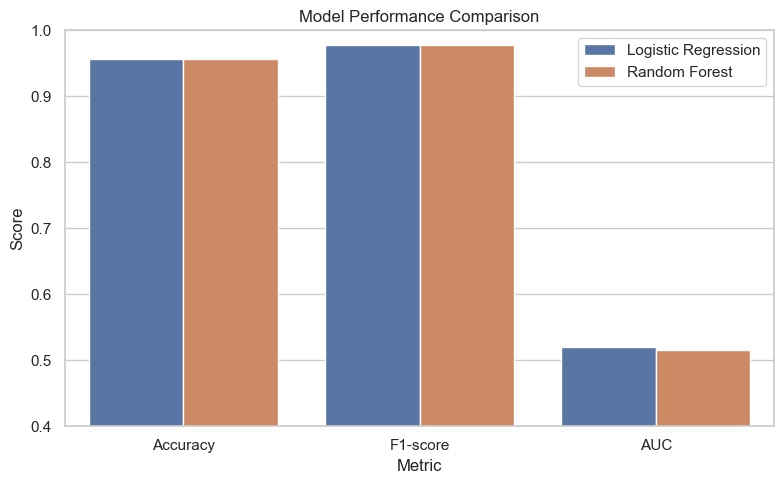

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 模型表現 dataframe：results（來自你模型訓練後的結果）
sns.set(style="whitegrid")
results_melted = results.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(8, 5))
sns.barplot(data=results_melted, x="Metric", y="Score", hue="Model")
plt.title("Model Performance Comparison")
plt.ylim(0.4, 1.0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Confusion Matrix

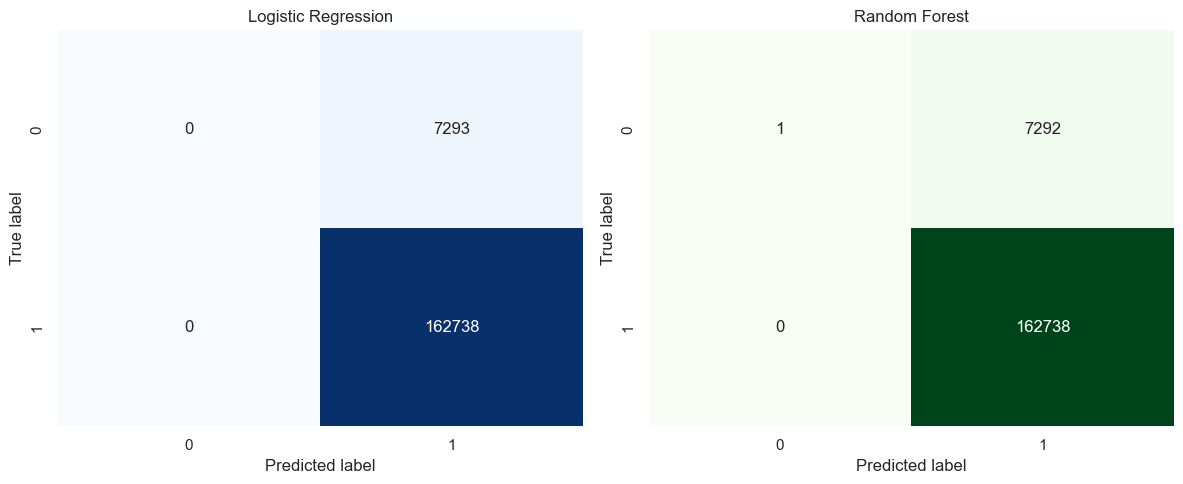

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 計算混淆矩陣
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# 畫圖
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
ax[0].set_title("Logistic Regression")
ax[0].set_xlabel("Predicted label")
ax[0].set_ylabel("True label")

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax[1], cbar=False)
ax[1].set_title("Random Forest")
ax[1].set_xlabel("Predicted label")
ax[1].set_ylabel("True label")

plt.tight_layout()
plt.show()

ROC curve

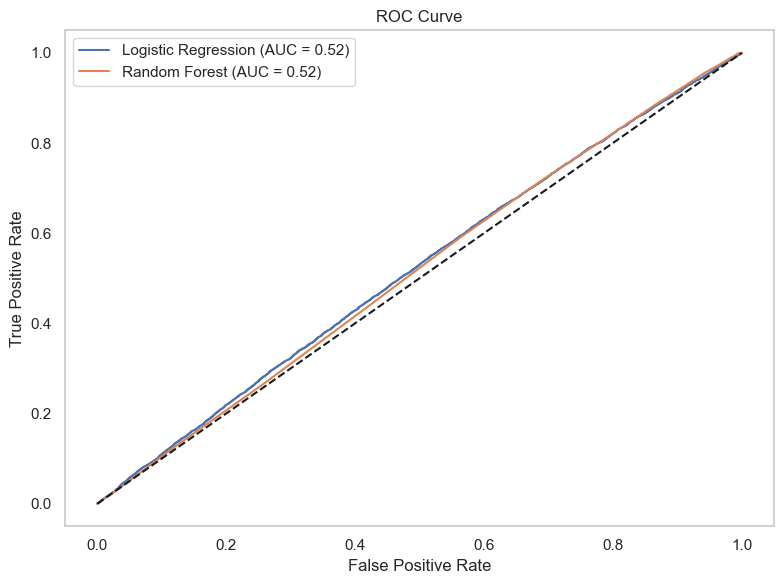

In [12]:
from sklearn.metrics import roc_curve, auc

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {logreg_auc:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Device Types and Conversion

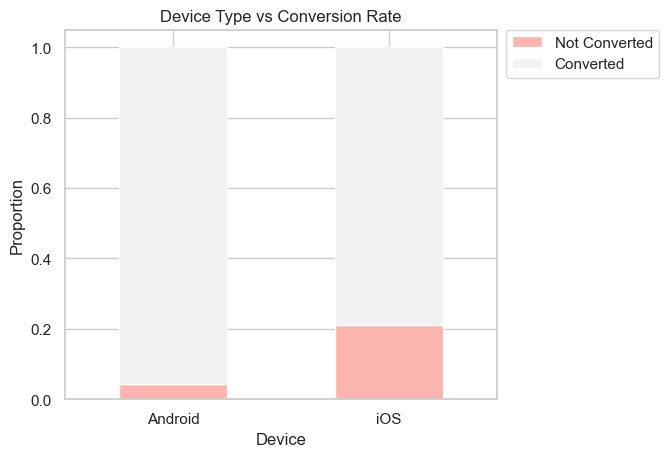

In [18]:
device_df = df[['device_Android', 'device_iOS', 'converted']].copy()
device_df['device'] = device_df.apply(lambda row: 'Android' if row['device_Android']==1 else 'iOS', axis=1)
device_ct = pd.crosstab(device_df['device'], device_df['converted'], normalize='index')

device_ct.plot(kind='bar', stacked=True, colormap='Pastel1')
plt.title("Device Type vs Conversion Rate")
plt.ylabel("Proportion")
plt.xlabel("Device")
plt.xticks(rotation=0)
plt.legend(["Not Converted", "Converted"],
           loc='upper left', bbox_to_anchor=(1.02, 1),
           borderaxespad=0.)

plt.subplots_adjust(right=0.8)
plt.show()

hour_of_day

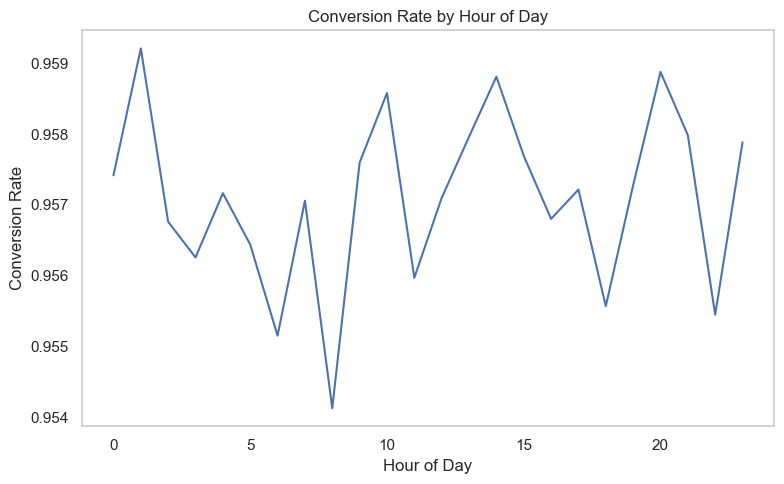

In [20]:
conversion_by_hour = df.groupby('hour_of_day')['converted'].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(x=conversion_by_hour.index, y=conversion_by_hour.values)
plt.title("Conversion Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Conversion Rate")
plt.grid()
plt.tight_layout()
plt.show()

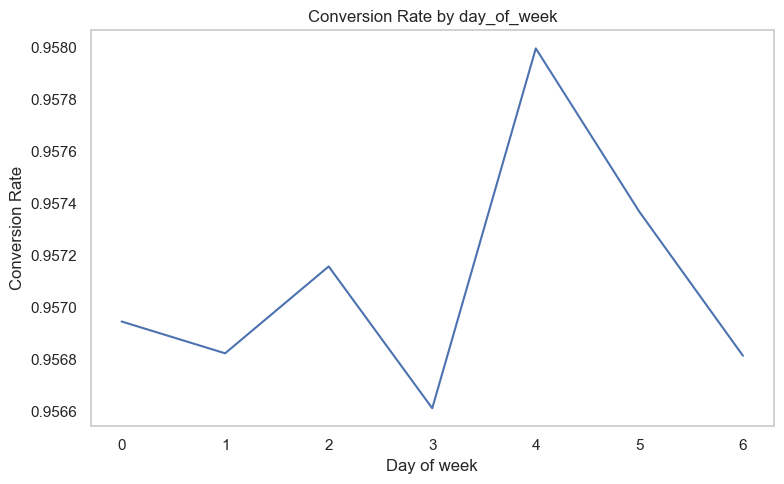

In [13]:
conversion_by_hour = df.groupby('day_of_week')['converted'].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(x=conversion_by_hour.index, y=conversion_by_hour.values)
plt.title("Conversion Rate by day_of_week")
plt.xlabel("Day of week")
plt.ylabel("Conversion Rate")
plt.grid()
plt.tight_layout()
plt.show()

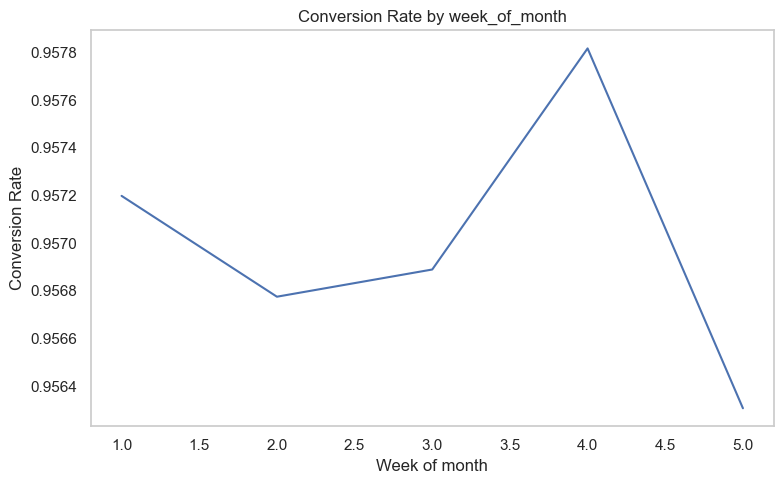

In [14]:
conversion_by_hour = df.groupby('week_of_month')['converted'].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(x=conversion_by_hour.index, y=conversion_by_hour.values)
plt.title("Conversion Rate by week_of_month")
plt.xlabel("Week of month")
plt.ylabel("Conversion Rate")
plt.grid()
plt.tight_layout()
plt.show()

Product Category

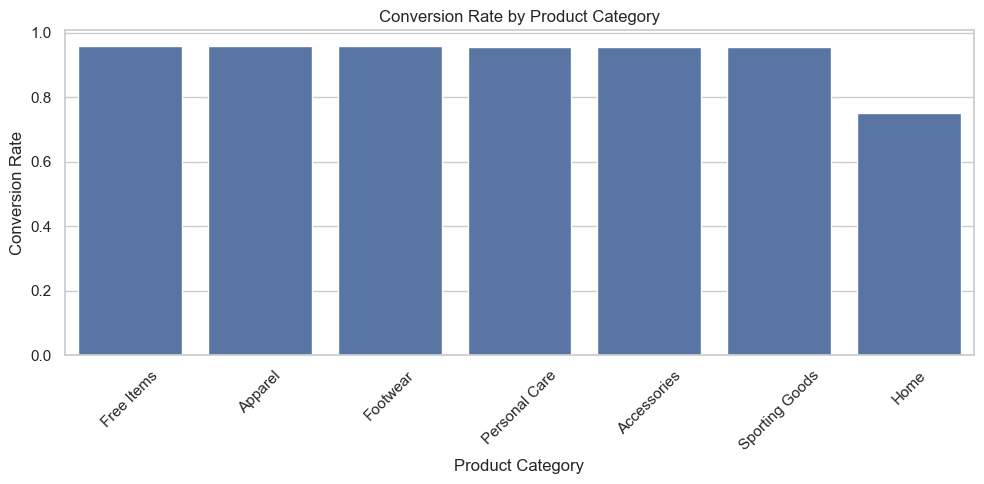

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# 選出所有 category_xxx 欄位
category_cols = [col for col in df.columns if col.startswith('category_') and col != 'category_Unknown']

# 建立空的 dict 收轉換率
conversion_rates = {}

# 每一類別個別計算 converted=1 的比例
for col in category_cols:
    mask = df[col] == 1
    if mask.sum() > 0:
        rate = df.loc[mask, 'converted'].mean()
        conversion_rates[col.replace('category_', '')] = rate

# 畫圖
conversion_series = pd.Series(conversion_rates).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=conversion_series.index, y=conversion_series.values)
plt.xticks(rotation=45)
plt.xlabel("Product Category")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate by Product Category")
plt.tight_layout()
plt.show()


Color and conversion rate

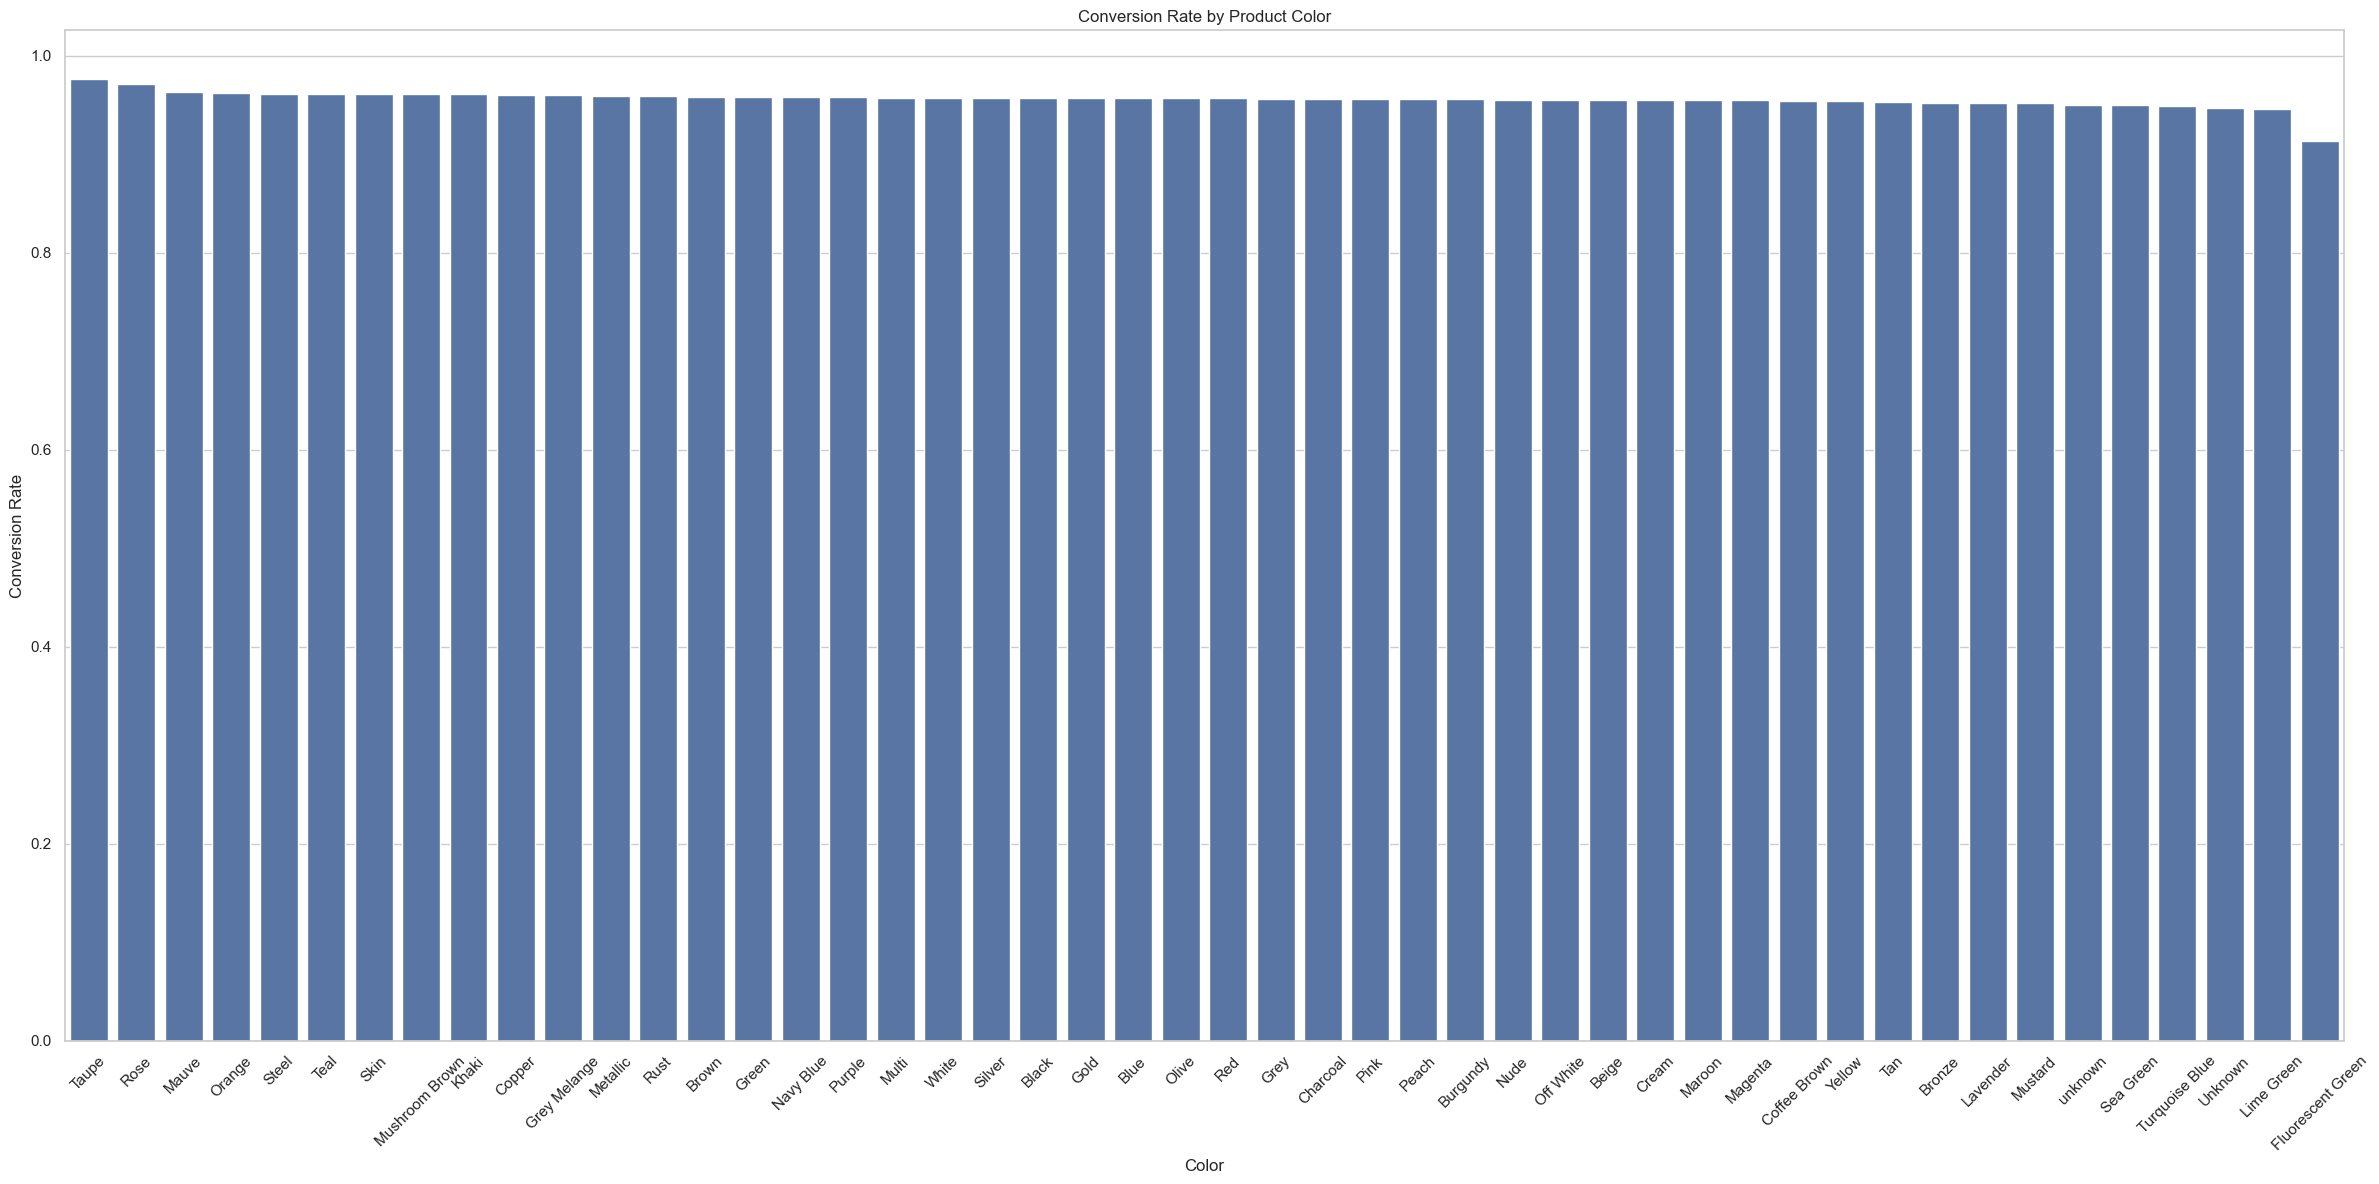

In [16]:
color_cols = [col for col in df.columns if col.startswith('color_')]

color_conversion = {}
for col in color_cols:
    conversion = df[df[col] == 1]['converted'].mean()
    color_conversion[col.replace("color_", "")] = conversion

color_df = pd.DataFrame.from_dict(color_conversion, orient='index', columns=['conversion_rate'])
color_df = color_df.sort_values(by='conversion_rate', ascending=False)

plt.figure(figsize=(24, 12))
sns.barplot(x=color_df.index, y=color_df['conversion_rate'])
plt.title("Conversion Rate by Product Color")
plt.xlabel("Color")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
